# INIT

In [1]:
from modules.node import VideoReader, Tracker, Render
from modules.FaceMesh import FaceMeshHandler
from queue import Queue
from multiprocessing import Queue as mpQueue
from pathlib import Path
from typing import cast

from omegaconf import OmegaConf, DictConfig

def load_dict_config(path: Path) -> DictConfig:
    conf = OmegaConf.load(path)
    if not isinstance(conf, DictConfig):
        raise TypeError(f"Config at {path} must be a DictConfig, got {type(conf).__name__}")
    return cast(DictConfig, conf)

app_conf = load_dict_config(Path('configs/app.json'))

frame_queue = Queue(maxsize=2)
tracker_queue = mpQueue(maxsize=2)

video_reader = VideoReader(app_conf.video_reader, frame_queue)
face_mesh_handler = FaceMeshHandler(app_conf.face_mesh)
tracker = Tracker(app_conf.tracker, face_mesh_handler, frame_queue, tracker_queue)
render = Render(app_conf.render, tracker_queue)

video_reader_conf = app_conf.video_reader

# LANDMARKS VISUALIZATION

In [2]:
import threading
import cv2
import queue

thread_video_reader = threading.Thread(target=video_reader.start, daemon=True)
thread_tracker = threading.Thread(target=tracker.start, daemon=True)

thread_video_reader.start()
thread_tracker.start()

try:
    while True:
        try:
            tracker_payload = tracker_queue.get(timeout=0.5)
        except queue.Empty:
            if not thread_video_reader.is_alive():
                break
            continue

        if tracker_payload.frame is None:
            continue

        frame = tracker_payload.frame
        if video_reader_conf.target_format == "rgb":
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        h, w = frame.shape[:2]
        if tracker_payload.state != "LOST":
            for lm in tracker_payload.landmarks:
                x = int(lm.x * w)
                y = int(lm.y * h)
                if 0 <= x < w and 0 <= y < h:
                    cv2.circle(frame, (x, y), 1, (0, 255, 0), -1)

        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
finally:
    video_reader.stop()
    tracker.stop()
    thread_video_reader.join(timeout=1)
    thread_tracker.join(timeout=1)
    cv2.destroyAllWindows()

# GET LANDMARKS AND BLENDSHAPES

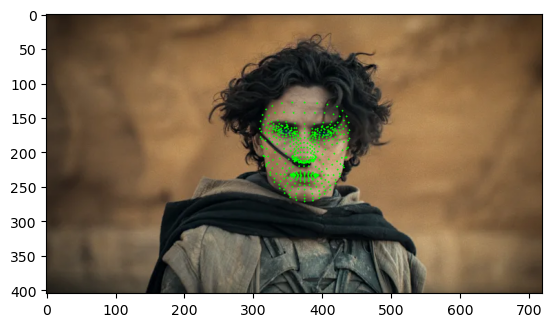

52

In [ ]:
import cv2
import matplotlib.pyplot as plt

frame = cv2.imread("image/tests/timoty.png") # uint8, BGR
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
res = face_mesh_handler.process_frame_3d(frame)

landmarks = res.face_landmarks[0] # List[NormalizedLandmark(x, y, z, visibility, presence, name) ...], len = 478
blendshapes = res.face_blendshapes[0] # List[Category(index, score, display_name, category_name) ...], len = 52

h, w = frame.shape[:2]

for lamdmark in landmarks:
    x = int(lamdmark.x * w)
    y = int(lamdmark.y * h)
    cv2.circle(frame, (x,y), 1, (0,255,0), -1)
    
plt.imshow(frame)
plt.show()
